In [1]:
%matplotlib inline
import sys, os, time
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import cv2

In [2]:
def humansize(nbytes):
    '''From https://stackoverflow.com/questions/14996453/python-libraries-to-calculate-human-readable-filesize-from-bytes'''
    suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
    i = 0
    while nbytes >= 1024 and i < len(suffixes)-1:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
    return '%s %s' % (f, suffixes[i])

## Preprocess images

In [3]:
fns = os.listdir("data/val")
fns.sort()
fns = [
    "data/val/" + fn
    for fn in fns
]

In [4]:
x_val = np.zeros((len(fns), 224, 224, 3), dtype=np.float32)
print(humansize(x_val.nbytes))

28.04 GB


In [5]:
%%time

for i in range(len(fns)):
    if i %2000 == 0:
        print("%d/%d" % (i, len(fns)))
    
    # Load (as BGR)
    img = cv2.imread(fns[i])
    
    # Resize
    height, width, _ = img.shape
    new_height = height * 256 // min(img.shape[:2])
    new_width = width * 256 // min(img.shape[:2])
    img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    
    # Crop
    height, width, _ = img.shape
    startx = width//2 - (224//2)
    starty = height//2 - (224//2)
    img = img[starty:starty+224,startx:startx+224]
    assert img.shape[0] == 224 and img.shape[1] == 224, (img.shape, height, width)
    
    # Save (as RGB)
    x_val[i,:,:,:] = img[:,:,::-1]

0/50000
2000/50000
4000/50000
6000/50000
8000/50000
10000/50000
12000/50000
14000/50000
16000/50000
18000/50000
20000/50000
22000/50000
24000/50000
26000/50000
28000/50000
30000/50000
32000/50000
34000/50000
36000/50000
38000/50000
40000/50000
42000/50000
44000/50000
46000/50000
48000/50000
CPU times: user 5min 59s, sys: 1min 26s, total: 7min 26s
Wall time: 3min 15s


### Save all

In [6]:
%%time

np.save("data/x_val.npy", x_val)

CPU times: user 0 ns, sys: 18.2 s, total: 18.2 s
Wall time: 3min 23s


### Save in chunks

In [ ]:
for i in range(0,50000,10000):
    np.save("data/x_val_%d_%d.npy" % (i, i+10000), x_val[i:i+10000])

## Mapping between different label types

In [8]:
meta = scipy.io.loadmat("data/meta.mat")
original_idx_to_synset = {}
synset_to_name = {}

for i in range(1000):
    ilsvrc2012_id = int(meta["synsets"][i,0][0][0][0])
    synset = meta["synsets"][i,0][1][0]
    name = meta["synsets"][i,0][2][0]
    original_idx_to_synset[ilsvrc2012_id] = synset
    synset_to_name[synset] = name

synset_to_keras_idx = {}
keras_idx_to_name = {}
f = open("data/synset_words.txt","r")
idx = 0
for line in f:
    parts = line.split(" ")
    synset_to_keras_idx[parts[0]] = idx
    keras_idx_to_name[idx] = " ".join(parts[1:])
    idx += 1
f.close()

def convert_original_idx_to_keras_idx(idx):
    return synset_to_keras_idx[original_idx_to_synset[idx]]

In [9]:
f = open("data/ILSVRC2012_validation_ground_truth.txt","r")
y_val = f.read().strip().split("\n")
y_val = list(map(int, y_val))
y_val = np.array([convert_original_idx_to_keras_idx(idx) for idx in y_val])
f.close()

In [10]:
np.save("data/y_val.npy", y_val)

## Show example images

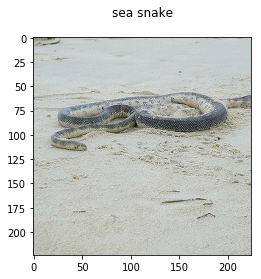

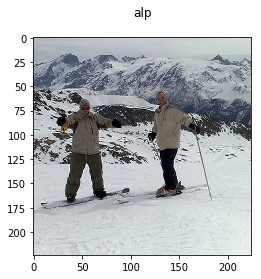

In [11]:
for i in range(2):
    plt.figure()
    plt.imshow(x_val[i] / 255.0)
    plt.title(keras_idx_to_name[y_val[i]])
    plt.show()
    plt.close()